<h1 style="text-align:center; font-size:50px;">Trabajo Fin de Grado</h1>

* * *

<h1 style="text-align:center; font-size:30px;">Elaboración de un modelo numérico de interior estelar</h1>

* * *

# 1. Objetivo

Realizar un modelo númerico de interior estelar. Dispondremos como datos iniciales de la masa total $M_{Tot}$, y la composición química {$X_{z}$}, la cual vendrá especificada mediante las fracciones en masa de hidrógeno $X$, y de helio $Y$.

Para nuestro modelo, la estrella constará de un núcleo convectivo y de una envoltura radactiva.

# 2. Introducción Teórica

Hipótesis iniciales:
1. Modelo homogéneo, la composición química será constante en toda la estrella. El material estará completamente ionizado.
2. Emplearemos como ecuación de estado la de los gases perfectos no degenerados.
3. Cuando exista convección, esta será adiabática.

Ecuaciones fundamentales del interior estelar:
1. Ecuación de continuidad de la masa
$$ \frac{dM(r)}{dr} = 4 \pi r^2 \rho $$
2. Ecuación de equilibrio hidrostático
$$ \frac{dP(r)}{dr} = - \frac{GM(r)}{r^2} \rho $$
3. Ecuación de equilibrio energético
$$ \frac{dL(r)}{dr} = 4 \pi r^2 \rho \varepsilon $$
4. Ecuación de tranporte de energía <br>
Transporte radiactivo
$$ \frac{dT(r)}{dr} = \frac{-3}{16 \pi a c} \frac{\kappa \rho}{T^3} \frac{L(r)}{r^2} $$
Transporte convectivo
$$ \frac{dT(r)}{dr} = -0.4 \frac{T}{P} \frac{GM(r)}{r^2} \rho $$

# 3. Modelo de Prueba

Vamos a realizar un modelo numérico del interior estelar a través de un modelo de prueba. Utilizaremos los siguientes parámetros iniciales:

<p style="text-align:center;"> $M_{Tot} = 5.0 x 10^{33} g$ &emsp; $X = 0.75$ &emsp; $Y = 0.22$<p>

### Unidades

In [2]:
# Units that we are going to adopt for the different magnitudes

r = 10**10  #cm (radius)
P = 10**15  #din cm−2 (pressure)
T = 10**7   #K (temperatura)
M = 10**33  #g (mass)
L = 10**33  #erg s−1 (luminosity)
rho = 1     #g cm−3 (density)
epsilon = 1 #erg g−1 s−1 (energy rate production)
kappa = 1   #cm2 g−1 (opacity)

### Peso molecular medio
Es un factor que aparece en muchas fórmulas y por eso es preciso determinarlo. Supondremos que la estrella es homogénea en composición química y que el material está completamente ionizado. Lo calculamos a través de la siguiente expresión:
$$\mu = \frac{1}{2X + \frac{3}{4}Y + \frac{1}{2}Y}$$

In [3]:
X = 0.75      # Hydrogen fraction
Y = 0.22      # Helium fraction
Z = 1 - X - Y # Heavy elements fractio

mu = 1 / (2*X + 0.75*Y + 0.5*Z)

### Ritmo de generación de energía

Puede aproximarse por la siguiente ecuación:

$$\varepsilon = \varepsilon_{1} X_{1} X_{2} \rho \left(\frac{T}{10^6}\right)^\nu$$

La fracción en masa $X_{1}$ y $X_{2}$ dependen del ciclo de generación de energía asumido, ya sea, el p-p chain o el CNO cycle. 
1. p-p chain. $X_{1} = X_{2} = X$, la fracción en masa de hidrógeno.
2. CNO cycle. $X_{1} = X$, la fracción en masa de hidrógeno y $X_{2} = X_{CN} = \frac{1}{3}Z$, la fracción en masa de elementos pesados.

Otros aspectos importantes a tener en cuenta es:
1. Resultará muy útil programar el cálculo del ritmo de genereación de energía como una funció que dependa de la temperatura.
2. Para cada temperatura habrá que comparar el ritmo de generación de energía en el p-p chain y el CNO cycle, adoptando el correspondiente al ciclo que genere más energía.
3. Si la temperatura sale del intervalo de los dos ciclos, se asumirá que el ritmo de generación de energía es cero.

In [4]:
# We define a function to study if the temperature is inside the interval

def inside(T1,T2,T):
    check = False
    if T >= T1 and T <= T2:
        check = True
    return check


# Energy rate production for p-p chain
# Interval -> [T1, T2, log_10(epsilon), nu]

interval_PP = [
    [4.0, 6.0, -6.84, 6.0],
    [6.0, 9.5, -6.04, 5.0],
    [9.5, 12.0, -5.56, 4.5], 
    [12.0, 16.5, -5.02, 4.0], 
    [16.5, 24.0, -4.40, 3.5] 
]

def epsilonPP(T):
    global X, rho, interval_PP
    
    T *= 10
    nu = 0
    epsilon1 = 0 
    X1 = X2 = X
    for interval in interval_PP:
        if inside(interval[0], interval[1], T):
            epsilon1 = 10**interval[2]
            nu = interval[3]
        
    return epsilon1 * X1 * X2 * rho * T ** nu


# Energy rate production for CNO cycle
# Interval -> [T1, T2, log_10(epsilon), nu]

interval_CNO = [
    [12.0, 16.0, -22.2, 20],
    [16.0, 22.5, -19.8, 18],
    [22.5, 27.5, -17.1, 16],
    [27.5, 36.0, -15.6, 15],
    [36.0, 50.0, -12.5, 13]
]

def epsilonCNO(T):
    global X, Z, rho, interval_CNO
    
    T *= 10
    nu = 0
    epsilon1 = 0 
    X1 = X
    X2 = Z/3
    for interval in interval_CNO:
        if inside(interval[0], interval[1], T):
            epsilon1 = 10**interval[2]
            nu = interval[3]
        
    return epsilon1 * X1 * X2 * rho * T ** nu


# Finally the energy rate production will be the biggest between th p-p chain and th CNO cycle

def Epsilon(T):
    return max(epsilonPP(T), epsilonCNO(T))


def Dom_epsilon(T):
    
    epsilon = max(epsilonPP(T), epsilonCNO(T))
    
    if epsilon == 0:
        return "--"
    elif epsilon == epsilonPP(T):
        return "PP"
    else:
        return "CN"


### Interacción del algoritmo Predictor - Corrector
Un paso importante del algoritmo es cuando toca decidir si una magnitud calculda $\nu_{i+1}^{cal}$ es suficientemente igual a una estimación preia de dicha magnitud $\nu_{i+1}^{est}$. Con lo cual realizaremos una comparación de este tipo:
$$ \frac{| \nu_{i+1}^{cal} - \nu_{i+1}^{est} |}{\nu_{i+1}^{val}} < E_{relativo,máximo} $$  
Calcula el error relativo en valor absoluto, nos da igual que la diferencia sea por exceso o defecto. Para los cálculos tomaremos que $E_{relativo,máximo} = 0.0001 $

In [5]:
# We define a function to study if the calculations should be repeat or not

def relError(cal,est):
    
    check = False # Repeat
    maximum = 0.0001
    if abs(cal - est) / cal < maximum:
        check = True # Not repeat
        
    return check

### Valores iniciales
Precisamos de unos valores iniciales para el radio total $R_{Tot}$ y la luminosidad total $L_{Tot}$, además de la temperatua central $T_{c}$ para cuando tengamos que realizar la integración desde el centro de la estrella hacia afuera

In [6]:
# We define the initial values

RTot = 11.5 # Total radius
LTot = 70   # Total Luminosity
MTot = 5    # Total mass
Tc = 2.0    # Center temperature

### Integración desde la superficie
Vamos a aplicar el método de diferencias, utilizando a lo sumo diferencias de orden dos, es decir:
$$ \Delta_{i}^1 = hf_i - hf_{i-1} $$
$$ \Delta_{i}^2 = \Delta_{i}^1 - \Delta_{i-1}^1 = hf_i - 2hf_{i-1} + hf_{i-2} $$
$$ \Delta_{i+1}^1 = hf_{i+1} - hf_i $$
$$ \Delta_{i+1}^2 = \Delta_{i+1}^1 - \Delta_{i}^1 = hf_{i+1} - 2hf_{i} + hf_{i-1} $$

Donde $f_i \equiv \left(\frac{d\nu}{dz}\right)_i$ es el resultado de evaluar una ecuación diferencial en la capa número i, y h es el paso de integración. Para el caso de $\Delta_{i}^2$ necesitamos estimar los valores de las diferentes magnitudes físicas en tres capas.

Para las distintas capas del modelo será necesario calcular un valor $f_i$ para cada parámetro físico (presión, temperatura, masa, luminosidad), empleando las siguientes ecuaciones:
1. Caso radiactivo:
$$ \frac{dM(r)}{dr} = C_m \frac{P}{T} r^2 $$
$$ \frac{dP(r)}{dr} = -C_p \frac{P}{T} \frac{M(r)}{r^2}$$
$$ \frac{dL(r)}{dr} = C_l P^2 T^{\nu-2} r^2$$
$$ \frac{dT(r)}{dr} = -C_t \frac{P^2}{T^{8.5}} \frac{L(r)}{r^2}$$

1. Caso convectivo:
$$ \frac{dM(r)}{dr} = C_m K' T^{1.5} r^2 $$
$$ \frac{dP(r)}{dr} = -C_p K' T^{1.5} \frac{M(r)}{r^2}$$
$$ \frac{dL(r)}{dr} = C_l  K'^2 T^{3+\nu} r^2$$
$$ \frac{dT(r)}{dr} = -C'_t \frac{L(r)}{r^2}$$

Donde las constantes tienes los siguiente valores:
$$C_m = 0.01523 \mu$$
$$C_p = 8.084 \mu$$
$$C_l = 0.01845 \varepsilon_1 X_1 X_2 10^\nu \mu^2$$
$$C_t = 0.01679 Z (1+X) \mu^2$$
$$C'_t = 3.234 \mu$$

Vamos a utilizar un radio inicial algo inferior al radio total $R_{Tot}$, de lo contrario, podemos encontrarnos con problemas de convergencia. Usaremos $R_{ini} = 0.9 R_{Tot}$


In [7]:
# We are going to define the functions to calculate the different physical parameters
# First for the radioactive surface

def M_fi_rad(P, T, r):
    global mu
    
    return 0.01523 * mu * P * r**2 / T


def P_fi_rad(P, T, r, M):
    global mu
    
    return -1 * 8.084 * mu * P * M / (T * r**2)


def T_fi_rad(P, T, r, L):
    global mu, Z, X
    
    return -1 * 0.01679 * Z * (1+X) * mu**2 * P**2 * L / (T**8.5 * r**2)


def L_fi_rad(P, T, r):
    global mu, Epsilon
    
    return 0.01845 * Epsilon(T) * mu**2 * P**2 * r**2 / T**2


# Second for the convective core

def M_fi_conv(T, r):
    global mu, K
    
    return 0.01523 * mu * K * T**1.5 * r**2


def P_fi_conv(T, r, M):
    global mu, K
    
    return -1 * 8.084 * mu * K * T**1.5 * M / r**2


def T_fi_conv(M, r):
    global mu
    
    return -1 * 3.234 * mu * M / r**2


def L_fi_conv(T, r):
    global mu, Epsilon, K
    
    return 0.01845 * Epsilon(T) * mu**2 * K**2 * T**3 * r**2

In [8]:
Rini = 0.9 * RTot

### Paso de integración y número de capas
Una vez determinado el radio inicial, debemos fijar el número de capas, en este caso, será del orden de la centena. Por lo que:
$$h = - \frac{R_{ini}}{100}$$
El valor será negativo al integrar de la superficie hacia el centro y positivo al integrar del cetro a la superficie.

In [9]:
h = - Rini / 100

### Primeras tres capas
Para las primeras tres capas, asumiremo que en la luminosidad es igual a $L_{Tot}$ y la masa es $M_{Tot}$, para calcular la presión y la temperatura, usaremos las siguientes expresiones:
$$ T = A_1 \left(\frac{1}{r} - \frac{1}{R_{Tot}}\right), A_1 = 1.9022 \mu M_{Tot}$$
$$ P = A_2 T^{4.25}, A_2 = 10.645 \sqrt{\frac{1}{\mu Z (1+X)} \frac{M_{Tot}}{L_{Tot}}}$$

In [10]:
# First as we are goint to use a square root in the formula, we have to import it from numpy
from numpy import sqrt

# Then we define the functions to calcula the T(r) and P(T), hence we have to calcula the T first

def T_rad(r):
    global RTot, MTot, mu
    
    return 1.9022 * mu * MTot * ((1/r) - (1/RTot))

def P_rad(T):
    global mu, Z, X, MTot, LTot
    
    return 10.645 * T**4.25 * sqrt(MTot/(mu * Z * LTot * (1 + X)))


# Now we can use them in a loop to calculate our parameters in the first three shells
# First we can define a list to stock all f_i for each parameter (value in each shell)

fi_P = []
fi_T = []
fi_M = []
fi_L = []

shell = 0
print(" E" +2*" "+ "i" +5*" "+ "r" +10*" "+ "P" +10*" "+ "T" +9*" "+ "L" +10*" "+ "M")
while shell <= 2:
    
    # First we calculate the most basic parameters to keep up with the calculations
    r = Rini + shell*h
    Ti = T_rad(r)
    Pi = P_rad(Ti)
    Ei = Dom_epsilon(Ti)
    
    # At the same time we will stock all f_i for each parameter
    fi_P.append(P_fi_rad(Pi, Ti, r, MTot))
    fi_T.append(T_fi_rad(Pi, Ti, r, LTot))
    fi_M.append(0)
    fi_L.append(0)
    
    print("{}  {}  {:.5f}  {:.7f}  {:.7f}  {:.6f}  {:.6f}"
          .format(Ei, shell, r, Pi, Ti, LTot, MTot))
    shell += 1

 E  i     r          P          T         L          M
--  0  10.35000  0.0000697  0.0546986  70.000000  5.000000
--  1  10.24650  0.0001049  0.0602238  70.000000  5.000000
--  2  10.14300  0.0001534  0.0658616  70.000000  5.000000


### Algoritmo fase A.1.1
__Envoltura radiactiva, con luminosidad y masas constantes__<br>
Vamos a definir una función para que nos calculo $P_{i+1}^{est}$ y $T_{i+1}^{est}$

In [11]:
# We define:

# Estimated Pressure
def P_est_fun(Pi, fi_P):
    global h
    
    fi = fi_P[-1]
    fi_1 = fi_P[-2]
    fi_2 = fi_P[-3]
    return Pi + (h/12) * (23*fi - 16*fi_1 + 5*fi_2)


# Estimated Temperatere
def T_est_fun(Ti, fi_T):
    global h
    
    fi = fi_T[-1]
    fi_1 = fi_T[-2]
    return Ti + (h/2) * (3*fi - fi_1)


# Calculated Pressure, Temperature and Mass will have the same expression. We will define a general one
def Gen_cal_fun(Xi, fi1_X, fi_X):
    global h
    
    fi1 = fi1_X
    fi = fi_X[-1]
    return Xi + (h/2) * (fi1 + fi)


# Calculated Luminosity
def L_cal_fun(Li, fi1_L, fi_L):
    global h
    
    fi1 = fi1_L
    fi = fi_L[-1]
    fi_1 = fi_L[-1]
    return Li + (h/12) * (5*fi1 + 8*fi - fi_1)


Desde este momento podemos iterar el modelo y ver hasta donde llegamos

In [12]:

# First we have to calculate the value of the estimated pressure and temperatere
P_est = P_est_fun(Pi, fi_P)
T_est = T_est_fun(Ti, fi_T)
    
# Now we have the first parameters to start or calculation
    
check_T = False
while not(check_T):
    
    shell = len(fi_P) # Number of shell that we are studying
    fi1_P = P_fi_rad(P_est, T_est, Rini + shell*h, MTot) # fi_P of the new shell that we are studying
    P_cal = Gen_cal_fun(Pi, fi1_P, fi_P) # Pressure in the shell

    check_P = relError(P_cal, P_est) # We have to check the relative error
    while not(check_P): # If it False, the calculation will be repeat, with the conditon -> P_est = P_cal
        P_est = Gen_cal_fun(Pi, fi1_P, fi_P)
        fi1_P = P_fi_rad(P_est, T_est, Rini + shell*h, MTot)
        P_cal = Gen_cal_fun(Pi, fi1_P, fi_P)
        check_P = relError(P_cal, P_est) # Finally we re-check it, if still False, the loop will run again
        
    fi1_T = T_fi_rad(P_cal, T_est, Rini + shell*h, LTot) # fi_T of the new shell that we are studying
    T_cal = Gen_cal_fun(Ti, fi1_T, fi_T) # Temperatere in the shell
    
    check_T = relError(T_cal, T_est) # Finally we re-check it, if still False, the loop will run again
    T_est = Gen_cal_fun(Ti, fi1_T, fi_T)
    
# Knowing T_cal and P_cal, now we can calculate M_cal
fi1_M = M_fi_rad(P_cal, T_cal, Rini + shell*h)
M_cal = Gen_cal_fun(MTot, fi1_M, fi_M)

Desde este punto, podemos generar un codigo que nos calcule las tres primeras capas, y todas aquellas que cumpla la condición de $M_{i+1}^{cal} \simeq M_{Tot}$

In [13]:
fi_P = []
fi_T = []
fi_M = []
fi_L = []

shell = 0
print(" E" +3*" "+ "fase" +3*" " + "i" +5*" "+ "r" +10*" "+ "P" +10*" "+ "T" +9*" "+ "L" +10*" "+ "M")
while shell <= 2:
    r = Rini + shell*h
    Ti = T_rad(r)
    Pi = P_rad(Ti)
    Ei = Dom_epsilon(Ti)
    Mi = MTot
    Li = LTot
    
    fi_P.append(P_fi_rad(Pi, Ti, r, MTot))
    fi_T.append(T_fi_rad(Pi, Ti, r, LTot))
    fi_M.append(0)
    fi_L.append(0)
    
    print("{}  {}  {}  {:.5f}  {:.7f}  {:.7f}  {:.6f}  {:.6f}"
          .format(Ei, "INICIO", shell, r, Pi, Ti, LTot, MTot))
    shell += 1
    
check_M = True
while check_M:

    P_est = P_est_fun(Pi, fi_P)
    T_est = T_est_fun(Ti, fi_T)
    
    shell = len(fi_P)
    r = Rini + shell*h

    check_T = False
    while not(check_T):
 
        fi1_P = P_fi_rad(P_est, T_est, r, MTot) 
        P_cal = Gen_cal_fun(Pi, fi1_P, fi_P)

        check_P = relError(P_cal, P_est) 
        while not(check_P):
            P_est = P_cal
            fi1_P = P_fi_rad(P_est, T_est, r, MTot)
            P_cal = Gen_cal_fun(Pi, fi1_P, fi_P)
            check_P = relError(P_cal, P_est) 

        fi1_T = T_fi_rad(P_cal, T_est, r, LTot) 
        T_cal = Gen_cal_fun(Ti, fi1_T, fi_T) 

        check_T = relError(T_cal, T_est) 
        T_est = T_cal

    fi1_M = M_fi_rad(P_cal, T_cal, r)
    M_cal = Gen_cal_fun(MTot, fi1_M, fi_M)
    check_M = relError(M_cal, MTot)
    
    if check_M: # We have to create this condition or the last one will be printed
        Ei = Dom_epsilon(T_cal)
        print("{}  {}  {}  {:.5f}  {:.7f}  {:.7f}  {:.6f}  {:.6f}"
              .format(Ei, "A.1.1.", shell, r, P_cal, T_cal, LTot, MTot))

        fi_P.append(P_fi_rad(P_cal, T_cal, r, MTot))
        fi_T.append(T_fi_rad(P_cal, T_cal, r, LTot))
        fi_M.append(M_fi_rad(P_cal, T_cal, r))
        fi_L.append(0)

        Pi = P_cal
        Ti = T_cal
        Mi = M_cal


 E   fase   i     r          P          T         L          M
--  INICIO  0  10.35000  0.0000697  0.0546986  70.000000  5.000000
--  INICIO  1  10.24650  0.0001049  0.0602238  70.000000  5.000000
--  INICIO  2  10.14300  0.0001534  0.0658616  70.000000  5.000000
--  A.1.1.  3  10.03950  0.0002194  0.0716242  70.000000  5.000000
--  A.1.1.  4  9.93600  0.0003073  0.0775188  70.000000  5.000000
--  A.1.1.  5  9.83250  0.0004224  0.0835426  70.000000  5.000000


### Algoritmo fase A.1.2
__Envoltura radiactiva, con masa variable y luminosidad constante__<br>
A partir de este punto, la masa no puede considerarse constante. El argoritmo para esta fase, es bastante parecido al de la A.1.1, por lo que podremos reutilizar código, que nos facilitará la sintaxis.

In [14]:

print(" E" +3*" "+ "fase" +3*" " + "i" +5*" "+ "r" +10*" "+ "P" +10*" "+ "T" +9*" "+ "L" +10*" "+ "M")

check_L = True
while check_L:
    
    P_est = P_est_fun(Pi, fi_P) # Estimated Pressure
    T_est = T_est_fun(Ti, fi_T) # Estimated Temperature

    shell = len(fi_P)
    r = Rini + shell*h # Radius of the shell

    check_T = False # First of all we have to impose the following condition
    while not(check_T):

        # With this last values we can calculate the calculated mass
        fi1_M = M_fi_rad(P_est, T_est, r)
        M_cal = Gen_cal_fun(Mi, fi1_M, fi_M) # Calculated mass

        # Finally we can calculate the calculated pressure and then compare it with the relative error
        fi1_P = P_fi_rad(P_est, T_est, r, M_cal) 
        P_cal = Gen_cal_fun(Pi, fi1_P, fi_P)

        check_P = relError(P_cal, P_est) # Checked of the relative error
        while not(check_P):
            P_est = P_cal
            fi1_P = P_fi_rad(P_est, T_est, r, M_cal)
            P_cal = Gen_cal_fun(Pi, fi1_P, fi_P)
            check_P = relError(P_cal, P_est)

        # One we have a good P_cal, we can calculate T_cal
        fi1_T = T_fi_rad(P_cal, T_est, r, LTot) 
        T_cal = Gen_cal_fun(Ti, fi1_T, fi_T) 

        # Again we have to check if the relative error is lower than what we are looking for
        check_T = relError(T_cal, T_est) 
        T_est = T_cal
    
    # Finally we can calculate the Luminosity in each shell and study the relative error
    fi1_L = L_fi_rad(P_cal, T_cal, r)
    L_cal = L_cal_fun(LTot, fi1_L, fi_L)
    check_L = relError(L_cal, LTot)
    
    if check_L:
        Ei = Dom_epsilon(T_cal)
        print("{}  {}  {}  {:.5f}  {:.7f}  {:.7f}  {:.6f}  {:.6f}"
              .format(Ei, "A.1.2.", shell, r, P_cal, T_cal, LTot, MTot))

        fi_P.append(P_fi_rad(P_cal, T_cal, r, MTot))
        fi_T.append(T_fi_rad(P_cal, T_cal, r, LTot))
        fi_M.append(M_fi_rad(P_cal, T_cal, r))
        fi_L.append(L_fi_rad(P_cal, T_cal, r))

        Pi = P_cal
        Ti = T_cal
        Mi = M_cal
        Li = L_cal


 E   fase   i     r          P          T         L          M
--  A.1.2.  6  9.72900  0.0005712  0.0896954  70.000000  5.000000
--  A.1.2.  7  9.62550  0.0007616  0.0959792  70.000000  5.000000
--  A.1.2.  8  9.52200  0.0010026  0.1023979  70.000000  5.000000
--  A.1.2.  9  9.41850  0.0013051  0.1089555  70.000000  5.000000
--  A.1.2.  10  9.31500  0.0016817  0.1156568  70.000000  5.000000
--  A.1.2.  11  9.21150  0.0021473  0.1225066  70.000000  5.000000
--  A.1.2.  12  9.10800  0.0027191  0.1295098  70.000000  5.000000
--  A.1.2.  13  9.00450  0.0034175  0.1366718  70.000000  5.000000
--  A.1.2.  14  8.90100  0.0042660  0.1439981  70.000000  5.000000
--  A.1.2.  15  8.79750  0.0052920  0.1514944  70.000000  5.000000
--  A.1.2.  16  8.69400  0.0065273  0.1591667  70.000000  5.000000
--  A.1.2.  17  8.59050  0.0080088  0.1670212  70.000000  5.000000
--  A.1.2.  18  8.48700  0.0097790  0.1750643  70.000000  5.000000
--  A.1.2.  19  8.38350  0.0118873  0.1833027  70.000000  5.000000
-- 

Nuevamente podemos unir las tres primeras fases par que nos imprima todos lo valores de los parametros

In [15]:
fi_P = []
fi_T = []
fi_M = []
fi_L = []

shell = 0
print(" E" +3*" "+ "fase" +3*" " + "i" +5*" "+ "r" +10*" "+ "P" +10*" "+ "T" +9*" "+ "L" +10*" "+ "M")
while shell <= 2:
    r = Rini + shell*h
    Ti = T_rad(r)
    Pi = P_rad(Ti)
    Ei = Dom_epsilon(Ti)
    Mi = MTot
    Li = LTot
    
    fi_P.append(P_fi_rad(Pi, Ti, r, MTot))
    fi_T.append(T_fi_rad(Pi, Ti, r, LTot))
    fi_M.append(0)
    fi_L.append(0)
    
    print("{}  {}  {}  {:.5f}  {:.7f}  {:.7f}  {:.6f}  {:.6f}"
          .format(Ei,"INICIO", shell, r, Pi, Ti, LTot, MTot))
    shell += 1
    
check_M = True
while check_M:

    P_est = P_est_fun(Pi, fi_P)
    T_est = T_est_fun(Ti, fi_T)
    
    shell = len(fi_P)
    r = Rini + shell*h

    check_T = False
    while not(check_T):
 
        fi1_P = P_fi_rad(P_est, T_est, r, MTot) 
        P_cal = Gen_cal_fun(Pi, fi1_P, fi_P)

        check_P = relError(P_cal, P_est) 
        while not(check_P):
            P_est = P_cal
            fi1_P = P_fi_rad(P_est, T_est, r, MTot)
            P_cal = Gen_cal_fun(Pi, fi1_P, fi_P)
            check_P = relError(P_cal, P_est) 

        fi1_T = T_fi_rad(P_cal, T_est, r, LTot) 
        T_cal = Gen_cal_fun(Ti, fi1_T, fi_T) 

        check_T = relError(T_cal, T_est) 
        T_est = T_cal

    fi1_M = M_fi_rad(P_cal, T_cal, r)
    M_cal = Gen_cal_fun(MTot, fi1_M, fi_M)
    check_M = relError(M_cal, MTot)
    
    if check_M:
        
        Ei = Dom_epsilon(T_cal)
        print("{}  {}  {}  {:.5f}  {:.7f}  {:.7f}  {:.6f}  {:.6f}"
              .format(Ei,"A.1.1.", shell, r, P_cal, T_cal, LTot, MTot))

        fi_P.append(P_fi_rad(P_cal, T_cal, r, M_cal))
        fi_T.append(T_fi_rad(P_cal, T_cal, r, LTot))
        fi_M.append(M_fi_rad(P_cal, T_cal, r))
        fi_L.append(0)

        Pi = P_cal
        Ti = T_cal
        Mi = M_cal    

check_L = True
while check_L:
    
    P_est = P_est_fun(Pi, fi_P) 
    T_est = T_est_fun(Ti, fi_T) 

    shell = len(fi_P)
    r = Rini + shell*h 

    check_T = False 
    while not(check_T):
        
        fi1_M = M_fi_rad(P_est, T_est, r)
        M_cal = Gen_cal_fun(Mi, fi1_M, fi_M) 

        fi1_P = P_fi_rad(P_est, T_est, r, M_cal) 
        P_cal = Gen_cal_fun(Pi, fi1_P, fi_P)

        check_P = relError(P_cal, P_est)
        while not(check_P):
            P_est = P_cal
            fi1_P = P_fi_rad(P_est, T_est, r, M_cal)
            P_cal = Gen_cal_fun(Pi, fi1_P, fi_P)
            check_P = relError(P_cal, P_est)
        
        fi1_T = T_fi_rad(P_cal, T_est, r, LTot) 
        T_cal = Gen_cal_fun(Ti, fi1_T, fi_T) 
    
        check_T = relError(T_cal, T_est) 
        T_est = T_cal
    
    fi1_L = L_fi_rad(P_cal, T_cal, r)
    L_cal = L_cal_fun(LTot, fi1_L, fi_L)
    check_L = relError(L_cal, LTot)
    
    if check_L:
        
        Ei = Dom_epsilon(T_cal)
        print("{}  {}  {}  {:.5f}  {:.7f}  {:.7f}  {:.6f}  {:.6f}"
              .format(Ei,"A.1.2.", shell, r, P_cal, T_cal, LTot, M_cal))

        fi_P.append(P_fi_rad(P_cal, T_cal, r, M_cal))
        fi_T.append(T_fi_rad(P_cal, T_cal, r, L_cal))
        fi_M.append(M_fi_rad(P_cal, T_cal, r))
        fi_L.append(L_fi_rad(P_cal, T_cal, r))

        Pi = P_cal
        Ti = T_cal
        Mi = M_cal
        Li = L_cal

 E   fase   i     r          P          T         L          M
--  INICIO  0  10.35000  0.0000697  0.0546986  70.000000  5.000000
--  INICIO  1  10.24650  0.0001049  0.0602238  70.000000  5.000000
--  INICIO  2  10.14300  0.0001534  0.0658616  70.000000  5.000000
--  A.1.1.  3  10.03950  0.0002194  0.0716242  70.000000  5.000000
--  A.1.1.  4  9.93600  0.0003073  0.0775187  70.000000  5.000000
--  A.1.1.  5  9.83250  0.0004224  0.0835425  70.000000  5.000000
--  A.1.2.  6  9.72900  0.0005712  0.0896951  70.000000  4.999076
--  A.1.2.  7  9.62550  0.0007616  0.0959787  70.000000  4.998448
--  A.1.2.  8  9.52200  0.0010026  0.1023969  70.000000  4.997688
--  A.1.2.  9  9.41850  0.0013049  0.1089538  70.000000  4.996773
--  A.1.2.  10  9.31500  0.0016814  0.1156540  70.000000  4.995684
--  A.1.2.  11  9.21150  0.0021467  0.1225022  70.000000  4.994395
--  A.1.2.  12  9.10800  0.0027181  0.1295033  70.000000  4.992882
--  A.1.2.  13  9.00450  0.0034157  0.1366625  70.000000  4.991115
--  A

### Algoritmo fase A.1.2
__Envoltura radiactiva, con masa y luminosidad variables__<br>
A partir de este momento, no podemos considerar la luminosidad constante. Hasta el momento hemos asumido que el transporte de energía se produce de forma más eficiente por convección que por radiación. Lo cual seguiremos asumiendo hasta que sea lo contrario. Para ello estudiaremos el siguiente parametro $n$.
$$ n+1 = \frac{T_{i+1}^{cal}}{P_{i+1}^{cal}} \frac{\left(\frac{dP}{dr}\right)_{i+1}}{\left(\frac{dT}{dr}\right)_{i+1}}$$
Donde el transporte convectivo comenzará a ser importante a partir del momento en el que $n+1 \leq 2.5$

Por lo que comenzaremos por definir $n$.

In [16]:
# First we are going to define n+1:

def n_fun(T_cal, P_cal, fi1_P, fi1_T):
    return (T_cal * fi1_P) / (P_cal * fi1_T)


# Besides we can define a function that checks if the condition of radioactive surface is valid

def check_n_fun(n):
    
    check = True # It True that doesn't meet the condition
    if n <= 2.5:
        check = False
    
    return check


A partir de este momento tenemos todo definido para empezar a calcular los valores de los parametros estelares que estamos estudiando.

In [17]:

print(" E" +3*" "+ "fase" +3*" " + "i" +5*" "+
      "r" +10*" "+ "P" +10*" "+ "T" +9*" "+ "L" +10*" "+ "M" +8*" "+ "n+1")

check_n = True
while check_n:
    
    P_est = P_est_fun(Pi, fi_P) # Estimated Preassure
    T_est = T_est_fun(Ti, fi_T) # Estimated Temperature

    shell = len(fi_P) # Number of shell that we are studying
    r = Rini + shell*h # Radius of the shell

    # Same steps as before but with the difference that we use the Luminosity to calculate the Temperature
    check_T = False 
    while not(check_T):
        
        fi1_M = M_fi_rad(P_est, T_est, r)
        M_cal = Gen_cal_fun(Mi, fi1_M, fi_M) 

        fi1_P = P_fi_rad(P_est, T_est, r, M_cal) 
        P_cal = Gen_cal_fun(Pi, fi1_P, fi_P)

        check_P = relError(P_cal, P_est)
        while not(check_P):
            P_est = P_cal
            fi1_P = P_fi_rad(P_est, T_est, r, M_cal)
            P_cal = Gen_cal_fun(Pi, fi1_P, fi_P)
            check_P = relError(P_cal, P_est)
            
        fi1_L = L_fi_rad(P_cal, T_est, r)
        L_cal = L_cal_fun(Li, fi1_L, fi_L)
        
        fi1_T = T_fi_rad(P_cal, T_est, r, L_cal) 
        T_cal = Gen_cal_fun(Ti, fi1_T, fi_T) 
    
        check_T = relError(T_cal, T_est) 
        T_est = T_cal
        
    # Finally we have to check if or condition is still valid    
    n = n_fun(T_cal, P_cal, fi1_P, fi1_T)
    check_n = check_n_fun(n)
    
    if check_n:
        
        Ei = Dom_epsilon(T_cal)
        print("{}  {}  {}  {:.5f}  {:.7f}  {:.7f}  {:.6f}  {:.6f}  {:.6f}"
              .format(Ei,"A.1.3.", shell, r, P_cal, T_cal, L_cal, M_cal, n))

        fi_P.append(P_fi_rad(P_cal, T_cal, r, M_cal))
        fi_T.append(T_fi_rad(P_cal, T_cal, r, L_cal))
        fi_M.append(M_fi_rad(P_cal, T_cal, r))
        fi_L.append(L_fi_rad(P_cal, T_cal, r))

        Pi = P_cal
        Ti = T_cal
        Mi = M_cal
        Li = L_cal

 E   fase   i     r          P          T         L          M        n+1
PP  A.1.3.  60  4.14000  5.3908117  0.8018562  69.986685  3.321914  3.850875
PP  A.1.3.  61  4.03650  6.0757686  0.8272350  69.976562  3.211719  3.820395
PP  A.1.3.  62  3.93300  6.8357376  0.8532454  69.963175  3.097444  3.787753
PP  A.1.3.  63  3.82950  7.6765510  0.8798883  69.945570  2.979286  3.752781
PP  A.1.3.  64  3.72600  8.6040064  0.9071624  69.922554  2.857491  3.715336
PP  A.1.3.  65  3.62250  9.6237477  0.9350643  69.892650  2.732360  3.675270
PP  A.1.3.  66  3.51900  10.7411266  0.9635885  69.854547  2.604242  3.632400
PP  A.1.3.  67  3.41550  11.9610439  0.9927273  69.806735  2.473545  3.586539
PP  A.1.3.  68  3.31200  13.2877711  1.0224704  69.746770  2.340727  3.537524
PP  A.1.3.  69  3.20850  14.7247572  1.0528053  69.672122  2.206302  3.485155
PP  A.1.3.  70  3.10500  16.2744223  1.0837171  69.579921  2.070832  3.429229
PP  A.1.3.  71  3.00150  17.9379450  1.1151886  69.466975  1.934925  3.369

Análogo a los pasos anteriores, podemos unir las 4 primeras fases en un mismo código

In [18]:
fi_P = []
fi_T = []
fi_M = []
fi_L = []

shell = 0
print(" E" +3*" "+ "fase" +3*" " + "i" +5*" "+ "r" +10*" "+ "P" +10*" "+ "T" +9*" "+ "L" +10*" "+ "M")
while shell <= 2:
    r = Rini + shell*h
    Ti = T_rad(r)
    Pi = P_rad(Ti)
    Ei = Dom_epsilon(Ti)
    Mi = MTot
    Li = LTot
    
    fi_P.append(P_fi_rad(Pi, Ti, r, MTot))
    fi_T.append(T_fi_rad(Pi, Ti, r, LTot))
    fi_M.append(0)
    fi_L.append(0)

    
    
    print("{}  {}  {}  {:.5f}  {:.7f}  {:.7f}  {:.6f}  {:.6f}"
          .format(Ei,"INICIO", shell, r, Pi, Ti, LTot, MTot))
    shell += 1
    
check_M = True
while check_M:

    P_est = P_est_fun(Pi, fi_P)
    T_est = T_est_fun(Ti, fi_T)
    
    shell = len(fi_P)
    r = Rini + shell*h

    check_T = False
    while not(check_T):
 
        fi1_P = P_fi_rad(P_est, T_est, r, MTot) 
        P_cal = Gen_cal_fun(Pi, fi1_P, fi_P)

        check_P = relError(P_cal, P_est) 
        while not(check_P):
            P_est = P_cal
            fi1_P = P_fi_rad(P_est, T_est, r, MTot)
            P_cal = Gen_cal_fun(Pi, fi1_P, fi_P)
            check_P = relError(P_cal, P_est) 

        fi1_T = T_fi_rad(P_cal, T_est, r, LTot) 
        T_cal = Gen_cal_fun(Ti, fi1_T, fi_T) 

        check_T = relError(T_cal, T_est) 
        T_est = T_cal

    fi1_M = M_fi_rad(P_cal, T_cal, r)
    M_cal = Gen_cal_fun(MTot, fi1_M, fi_M)
    check_M = relError(M_cal, MTot)
    
    if check_M:
        
        Ei = Dom_epsilon(T_cal)
        print("{}  {}  {}  {:.5f}  {:.7f}  {:.7f}  {:.6f}  {:.6f}"
              .format(Ei,"A.1.1.", shell, r, P_cal, T_cal, LTot, MTot))

        fi_P.append(P_fi_rad(P_cal, T_cal, r, M_cal))
        fi_T.append(T_fi_rad(P_cal, T_cal, r, LTot))
        fi_M.append(M_fi_rad(P_cal, T_cal, r))
        fi_L.append(0)

        Pi = P_cal
        Ti = T_cal
        Mi = M_cal    

check_L = True
while check_L:
    
    P_est = P_est_fun(Pi, fi_P) 
    T_est = T_est_fun(Ti, fi_T) 

    shell = len(fi_P)
    r = Rini + shell*h 

    check_T = False 
    while not(check_T):
        
        fi1_M = M_fi_rad(P_est, T_est, r)
        M_cal = Gen_cal_fun(Mi, fi1_M, fi_M) 

        fi1_P = P_fi_rad(P_est, T_est, r, M_cal) 
        P_cal = Gen_cal_fun(Pi, fi1_P, fi_P)

        check_P = relError(P_cal, P_est)
        while not(check_P):
            P_est = P_cal
            fi1_P = P_fi_rad(P_est, T_est, r, M_cal)
            P_cal = Gen_cal_fun(Pi, fi1_P, fi_P)
            check_P = relError(P_cal, P_est)
        
        fi1_T = T_fi_rad(P_cal, T_est, r, LTot) 
        T_cal = Gen_cal_fun(Ti, fi1_T, fi_T) 
    
        check_T = relError(T_cal, T_est) 
        T_est = T_cal
    
    fi1_L = L_fi_rad(P_cal, T_cal, r)
    L_cal = L_cal_fun(LTot, fi1_L, fi_L)
    check_L = relError(L_cal, LTot)
    
    if check_L:
        
        Ei = Dom_epsilon(T_cal)
        print("{}  {}  {}  {:.5f}  {:.7f}  {:.7f}  {:.6f}  {:.6f}"
              .format(Ei,"A.1.2.", shell, r, P_cal, T_cal, LTot, M_cal))

        fi_P.append(P_fi_rad(P_cal, T_cal, r, M_cal))
        fi_T.append(T_fi_rad(P_cal, T_cal, r, L_cal))
        fi_M.append(M_fi_rad(P_cal, T_cal, r))
        fi_L.append(L_fi_rad(P_cal, T_cal, r))

        Pi = P_cal
        Ti = T_cal
        Mi = M_cal
        Li = L_cal
    
check_n = True
while check_n:
    
    P_est = P_est_fun(Pi, fi_P) 
    T_est = T_est_fun(Ti, fi_T) 

    shell = len(fi_P) 
    r = Rini + shell*h 

    check_T = False 
    while not(check_T):
        
        fi1_M = M_fi_rad(P_est, T_est, r)
        M_cal = Gen_cal_fun(Mi, fi1_M, fi_M) 

        fi1_P = P_fi_rad(P_est, T_est, r, M_cal) 
        P_cal = Gen_cal_fun(Pi, fi1_P, fi_P)

        check_P = relError(P_cal, P_est)
        while not(check_P):
            P_est = P_cal
            fi1_P = P_fi_rad(P_est, T_est, r, M_cal)
            P_cal = Gen_cal_fun(Pi, fi1_P, fi_P)
            check_P = relError(P_cal, P_est)
            
        fi1_L = L_fi_rad(P_cal, T_est, r)
        L_cal = L_cal_fun(Li, fi1_L, fi_L)
        
        fi1_T = T_fi_rad(P_cal, T_est, r, L_cal) 
        T_cal = Gen_cal_fun(Ti, fi1_T, fi_T) 
    
        check_T = relError(T_cal, T_est) 
        T_est = T_cal
           
    n = n_fun(T_cal, P_cal, fi1_P, fi1_T)
    check_n = check_n_fun(n)
    
    if check_n:
        
        Ei = Dom_epsilon(T_cal)
        print("{}  {}  {}  {:.5f}  {:.7f}  {:.7f}  {:.6f}  {:.6f}  {:.6f}"
              .format(Ei,"A.1.3.", shell, r, P_cal, T_cal, L_cal, M_cal, n))

        fi_P.append(P_fi_rad(P_cal, T_cal, r, M_cal))
        fi_T.append(T_fi_rad(P_cal, T_cal, r, L_cal))
        fi_M.append(M_fi_rad(P_cal, T_cal, r))
        fi_L.append(L_fi_rad(P_cal, T_cal, r))

        Pi = P_cal
        Ti = T_cal
        Mi = M_cal
        Li = L_cal

 E   fase   i     r          P          T         L          M
--  INICIO  0  10.35000  0.0000697  0.0546986  70.000000  5.000000
--  INICIO  1  10.24650  0.0001049  0.0602238  70.000000  5.000000
--  INICIO  2  10.14300  0.0001534  0.0658616  70.000000  5.000000
--  A.1.1.  3  10.03950  0.0002194  0.0716242  70.000000  5.000000
--  A.1.1.  4  9.93600  0.0003073  0.0775187  70.000000  5.000000
--  A.1.1.  5  9.83250  0.0004224  0.0835425  70.000000  5.000000
--  A.1.2.  6  9.72900  0.0005712  0.0896951  70.000000  4.999076
--  A.1.2.  7  9.62550  0.0007616  0.0959787  70.000000  4.998448
--  A.1.2.  8  9.52200  0.0010026  0.1023969  70.000000  4.997688
--  A.1.2.  9  9.41850  0.0013049  0.1089538  70.000000  4.996773
--  A.1.2.  10  9.31500  0.0016814  0.1156540  70.000000  4.995684
--  A.1.2.  11  9.21150  0.0021467  0.1225022  70.000000  4.994395
--  A.1.2.  12  9.10800  0.0027181  0.1295033  70.000000  4.992882
--  A.1.2.  13  9.00450  0.0034157  0.1366625  70.000000  4.991115
--  A

### Algoritmo fase A.2. Núcleo convectivo
Dado que nuestra condición de que $n+1 \leq 2.5$ ya no se cumple, los cálculos realizados en dicha capa no son válidos y debemos repetirlos empleando un nuevo algoritmo. Aun así, los valores de presión y temperatura calculados, siguen siendo válidos, lo que nos permetirá calcular $K'$, la constante politrópica. El índice adiabático es $\gamma = 5/3$, correspodiente a un gas perfecto monoatómico.
$$K' = \frac{P_{i+1}^{cal}}{(T_{i+1}^{cal})^{2.5}}$$
Este valor $K'$, que calcularemos en la primera capa convectiva, se asumirá constante para el resto de capas, por lo que no hará falta calcularlo más veces. A partir de aquí ya podemos comenzar la integración.

In [19]:
# First of all we have to calculate the value of K' as it will be constant in all the algorithm

K = Pi / (Ti)**2.5

In [20]:
# The estimated pressare will be calculated through the polytrope model equation


print(" E" +3*" "+ "fase" +3*" " + "i" +5*" "+"r" +10*" "+
      "P" +10*" "+ "T" +9*" "+ "L" +10*" "+ "M" +9*" "+ "n+1")

while r > 0:

    T_est = T_est_fun(Ti, fi_T) # Estimated Temperature

    shell = len(fi_P) # Number of shell that we are studying
    r = Rini + shell*h # Radius of the shell
    
    if r > 0:

        # Same steps as before 
        check_T = False 
        while not(check_T):

            P_est = K * T_est**2.5 # Estimated Preassure through the polytrope equation

            fi1_M = M_fi_rad(P_est, T_est, r)
            M_cal = Gen_cal_fun(Mi, fi1_M, fi_M) 

            # In this case we are not calculating P_cal as before
            fi1_T = -3.234 * mu * M_cal / r**2
            T_cal = Gen_cal_fun(Ti, fi1_T, fi_T) 

            check_T = relError(T_cal, T_est) 
            T_est = T_cal

        P_cal = K * T_cal**2.5 

        # Knowing P_cal and T_cal we can calculate the Luminosit
        fi1_L = L_fi_rad(P_cal, T_cal, r)
        L_cal = L_cal_fun(Li, fi1_L, fi_L)
        
        Ei = Dom_epsilon(T_cal)
        print("{}  {}  {}  {:.5f}  {:.7f}  {:.7f}  {:.6f}  {:.6f}  {:.6f}"
              .format(Ei,"CONVEC", shell, r, P_cal, T_cal, L_cal, M_cal, n))
        
        # The first n+1 that will print is the one that has been calculated in the last code.
        # It corresponde to th i+1 shell, exactly the first that we are studying
        n = 0

        # From this point n+1 will be always 0
        
        fi_P.append(P_fi_rad(P_cal, T_cal, r, M_cal))
        fi_T.append(T_fi_rad(P_cal, T_cal, r, L_cal))
        fi_M.append(M_fi_rad(P_cal, T_cal, r))
        fi_L.append(L_fi_rad(P_cal, T_cal, r))

        Pi = P_cal
        Ti = T_cal
        Mi = M_cal
        Li = L_cal

 E   fase   i     r          P          T         L          M         n+1
PP  CONVEC  82  1.86300  42.3165500  1.4917669  66.097434  0.607118  2.379468
PP  CONVEC  83  1.75950  44.8481544  1.5268441  65.584376  0.518269  0.000000
CN  CONVEC  84  1.65600  47.4418874  1.5615707  65.025586  0.436522  0.000000
CN  CONVEC  85  1.55250  50.1043223  1.5960516  64.309538  0.361939  0.000000
CN  CONVEC  86  1.44900  52.8417212  1.6303755  63.309464  0.294518  0.000000
CN  CONVEC  87  1.34550  55.6594534  1.6646098  61.970844  0.234195  0.000000
CN  CONVEC  88  1.24200  58.5636805  1.6988233  60.203257  0.180849  0.000000
CN  CONVEC  89  1.13850  61.5600597  1.7330715  57.918634  0.134302  0.000000
CN  CONVEC  90  1.03500  64.6528455  1.7673881  55.032402  0.094319  0.000000
CN  CONVEC  91  0.93150  67.8430032  1.8017681  51.477499  0.060608  0.000000
CN  CONVEC  92  0.82800  71.1249534  1.8361395  47.226381  0.032822  0.000000
CN  CONVEC  93  0.72450  74.4808308  1.8703146  42.323016  0.010557

Por último uniremos el código de todas las fases para obtener el valor de los parametros en todas las capas.

In [21]:
fi_P = []
fi_T = []
fi_M = []
fi_L = []

shell = 0
print(" E" +3*" "+ "fase" +3*" " + "i" +5*" "+ "r" +10*" "
      + "P" +10*" "+ "T" +9*" "+ "L" +10*" "+ "M" +9*" "+ "n+1")
while shell <= 2:
    r = Rini + shell*h
    Ti = T_rad(r)
    Pi = P_rad(Ti)
    Ei = Dom_epsilon(Ti)
    Mi = MTot
    Li = LTot
    
    fi_P.append(P_fi_rad(Pi, Ti, r, MTot))
    fi_T.append(T_fi_rad(Pi, Ti, r, LTot))
    fi_M.append(0)
    fi_L.append(0)

    
    
    print("{}  {}  {}  {:.5f}  {:.7f}  {:.7f}  {:.6f}  {:.6f}"
          .format(Ei,"INICIO", shell, r, Pi, Ti, LTot, MTot))
    shell += 1
    
check_M = True
while check_M:

    P_est = P_est_fun(Pi, fi_P)
    T_est = T_est_fun(Ti, fi_T)
    
    shell = len(fi_P)
    r = Rini + shell*h

    check_T = False
    while not(check_T):
 
        fi1_P = P_fi_rad(P_est, T_est, r, MTot) 
        P_cal = Gen_cal_fun(Pi, fi1_P, fi_P)

        check_P = relError(P_cal, P_est) 
        while not(check_P):
            P_est = P_cal
            fi1_P = P_fi_rad(P_est, T_est, r, MTot)
            P_cal = Gen_cal_fun(Pi, fi1_P, fi_P)
            check_P = relError(P_cal, P_est) 

        fi1_T = T_fi_rad(P_cal, T_est, r, LTot) 
        T_cal = Gen_cal_fun(Ti, fi1_T, fi_T) 

        check_T = relError(T_cal, T_est) 
        T_est = T_cal

    fi1_M = M_fi_rad(P_cal, T_cal, r)
    M_cal = Gen_cal_fun(MTot, fi1_M, fi_M)
    check_M = relError(M_cal, MTot)
    
    if check_M:
        
        Ei = Dom_epsilon(T_cal)
        print("{}  {}  {}  {:.5f}  {:.7f}  {:.7f}  {:.6f}  {:.6f}"
              .format(Ei,"A.1.1.", shell, r, P_cal, T_cal, LTot, MTot))

        fi_P.append(P_fi_rad(P_cal, T_cal, r, M_cal))
        fi_T.append(T_fi_rad(P_cal, T_cal, r, LTot))
        fi_M.append(M_fi_rad(P_cal, T_cal, r))
        fi_L.append(0)

        Pi = P_cal
        Ti = T_cal
        Mi = M_cal    

check_L = True
while check_L:
    
    P_est = P_est_fun(Pi, fi_P) 
    T_est = T_est_fun(Ti, fi_T) 

    shell = len(fi_P)
    r = Rini + shell*h 

    check_T = False 
    while not(check_T):
        
        fi1_M = M_fi_rad(P_est, T_est, r)
        M_cal = Gen_cal_fun(Mi, fi1_M, fi_M) 

        fi1_P = P_fi_rad(P_est, T_est, r, M_cal) 
        P_cal = Gen_cal_fun(Pi, fi1_P, fi_P)

        check_P = relError(P_cal, P_est)
        while not(check_P):
            P_est = P_cal
            fi1_P = P_fi_rad(P_est, T_est, r, M_cal)
            P_cal = Gen_cal_fun(Pi, fi1_P, fi_P)
            check_P = relError(P_cal, P_est)
        
        fi1_T = T_fi_rad(P_cal, T_est, r, LTot) 
        T_cal = Gen_cal_fun(Ti, fi1_T, fi_T) 
    
        check_T = relError(T_cal, T_est) 
        T_est = T_cal
    
    fi1_L = L_fi_rad(P_cal, T_cal, r)
    L_cal = L_cal_fun(LTot, fi1_L, fi_L)
    check_L = relError(L_cal, LTot)
    
    if check_L:
        
        Ei = Dom_epsilon(T_cal)
        print("{}  {}  {}  {:.5f}  {:.7f}  {:.7f}  {:.6f}  {:.6f}"
              .format(Ei,"A.1.2.", shell, r, P_cal, T_cal, LTot, M_cal))

        fi_P.append(P_fi_rad(P_cal, T_cal, r, M_cal))
        fi_T.append(T_fi_rad(P_cal, T_cal, r, L_cal))
        fi_M.append(M_fi_rad(P_cal, T_cal, r))
        fi_L.append(L_fi_rad(P_cal, T_cal, r))

        Pi = P_cal
        Ti = T_cal
        Mi = M_cal
        Li = L_cal
    
check_n = True
while check_n:
    
    P_est = P_est_fun(Pi, fi_P) 
    T_est = T_est_fun(Ti, fi_T) 

    shell = len(fi_P) 
    r = Rini + shell*h 

    check_T = False 
    while not(check_T):
        
        fi1_M = M_fi_rad(P_est, T_est, r)
        M_cal = Gen_cal_fun(Mi, fi1_M, fi_M) 

        fi1_P = P_fi_rad(P_est, T_est, r, M_cal) 
        P_cal = Gen_cal_fun(Pi, fi1_P, fi_P)

        check_P = relError(P_cal, P_est)
        while not(check_P):
            P_est = P_cal
            fi1_P = P_fi_rad(P_est, T_est, r, M_cal)
            P_cal = Gen_cal_fun(Pi, fi1_P, fi_P)
            check_P = relError(P_cal, P_est)
            
        fi1_L = L_fi_rad(P_cal, T_est, r)
        L_cal = L_cal_fun(Li, fi1_L, fi_L)
        
        fi1_T = T_fi_rad(P_cal, T_est, r, L_cal) 
        T_cal = Gen_cal_fun(Ti, fi1_T, fi_T) 
    
        check_T = relError(T_cal, T_est) 
        T_est = T_cal
           
    n = n_fun(T_cal, P_cal, fi1_P, fi1_T)
    check_n = check_n_fun(n)
    
    if check_n:
        
        Ei = Dom_epsilon(T_cal)
        print("{}  {}  {}  {:.5f}  {:.7f}  {:.7f}  {:.6f}  {:.6f}  {:.6f}"
              .format(Ei,"A.1.3.", shell, r, P_cal, T_cal, L_cal, M_cal, n))

        fi_P.append(P_fi_rad(P_cal, T_cal, r, M_cal))
        fi_T.append(T_fi_rad(P_cal, T_cal, r, L_cal))
        fi_M.append(M_fi_rad(P_cal, T_cal, r))
        fi_L.append(L_fi_rad(P_cal, T_cal, r))

        Pi = P_cal
        Ti = T_cal
        Mi = M_cal
        Li = L_cal
        
K = Pi / (Ti)**2.5
        
while r > 0:

    T_est = T_est_fun(Ti, fi_T)

    shell = len(fi_P) 
    r = Rini + shell*h 
    
    if r > 0:

        check_T = False 
        while not(check_T):

            P_est = K * T_est**2.5 
            fi1_P = P_fi_rad(P_est, T_est, r, M_cal)

            fi1_M = M_fi_rad(P_est, T_est, r)
            M_cal = Gen_cal_fun(Mi, fi1_M, fi_M) 

            fi1_T = -3.234 * mu * M_cal / r**2
            T_cal = Gen_cal_fun(Ti, fi1_T, fi_T) 

            check_T = relError(T_cal, T_est) 
            T_est = T_cal

        P_cal = K * T_cal**2.5 

        fi1_L = L_fi_rad(P_cal, T_cal, r)
        L_cal = L_cal_fun(Li, fi1_L, fi_L)
        
        Ei = Dom_epsilon(T_cal)
        print("{}  {}  {}  {:.5f}  {:.7f}  {:.7f}  {:.6f}  {:.6f}  {:.6f}"
              .format(Ei,"CONVEC", shell, r, P_cal, T_cal, L_cal, M_cal, n))
        
        n = 0

        fi_P.append(P_fi_rad(P_cal, T_cal, r, M_cal))
        fi_T.append(T_fi_rad(P_cal, T_cal, r, L_cal))
        fi_M.append(M_fi_rad(P_cal, T_cal, r))
        fi_L.append(L_fi_rad(P_cal, T_cal, r))

        Pi = P_cal
        Ti = T_cal
        Mi = M_cal
        Li = L_cal

 E   fase   i     r          P          T         L          M         n+1
--  INICIO  0  10.35000  0.0000697  0.0546986  70.000000  5.000000
--  INICIO  1  10.24650  0.0001049  0.0602238  70.000000  5.000000
--  INICIO  2  10.14300  0.0001534  0.0658616  70.000000  5.000000
--  A.1.1.  3  10.03950  0.0002194  0.0716242  70.000000  5.000000
--  A.1.1.  4  9.93600  0.0003073  0.0775187  70.000000  5.000000
--  A.1.1.  5  9.83250  0.0004224  0.0835425  70.000000  5.000000
--  A.1.2.  6  9.72900  0.0005712  0.0896951  70.000000  4.999076
--  A.1.2.  7  9.62550  0.0007616  0.0959787  70.000000  4.998448
--  A.1.2.  8  9.52200  0.0010026  0.1023969  70.000000  4.997688
--  A.1.2.  9  9.41850  0.0013049  0.1089538  70.000000  4.996773
--  A.1.2.  10  9.31500  0.0016814  0.1156540  70.000000  4.995684
--  A.1.2.  11  9.21150  0.0021467  0.1225022  70.000000  4.994395
--  A.1.2.  12  9.10800  0.0027181  0.1295033  70.000000  4.992882
--  A.1.2.  13  9.00450  0.0034157  0.1366625  70.000000  4.

Finalmente hemos llegado al centro de la estrella. Como era de esperar, la temperatura y la presión aumentan al acercarnos al centro, pero las últimas capas, la masa se hace negativa, lo cual carece de sentido físico, es decir, que el modelo ha fallado en estas capas, como era de esperar. 

La forma de arreglar este problema será utilizar una temperatura central diferente a la estimada a través de la integración desde la superficie hacia el centro, con la esperanza de que en el límite entre la capa convectiva y la radiactiva se obtengan unos parámetros físicos similares que a los obtenidos en la integración desde la superficie.

### Valores en la frontera
Antes de comenzar con la integración desde el centro, nos será útil calcular el valor de los parámetros físicos en la frontera, es decir, entre la transición de la capa radiactiva a la convectiva de la estrella.

Hemos obtenido que el valor de $n+1$ en las capas $i=81$ e $i=82$, son $n+1=2.500934$ y $n+1=2.379468$
resptivamente, con un radio de $r=1.96650$ y $r=1.86300$ respectivamente, por lo que realizando una interpolación lineal obtenemos que para el caso $n+1=2.5$.
$$y = y_0 + \frac{y_1 - y_0}{x_1 - x_0} (x - x_0)$$
El radio es:

In [22]:
# We can define a function to calculate all the interpolations
def interpolation(y0,y1):
    
    n = 2.5
    n0 = 2.500934
    n1 = 2.379468 
    return y0 + ((y1 - y0) / (n1 - n0)) * (n - n0)


# We have obtained the values manually
R_rad = interpolation(1.96650, 1.86300)
P_rad = interpolation(39.8420132, 42.3165500)
T_rad = interpolation(1.4562414, 1.4917669)
L_rad = interpolation(66.582873, 66.097434)
M_rad = interpolation(0.702943, 0.607118)

print(3*" " + "r" +7*" " + "P" +7*" " + "T" +7*" " + "L" +7*" " + "M")
print("{:.4f}  {:.4f}  {:.4f}  {:.4f}  {:.4f}"
      .format(R_rad, P_rad, T_rad, L_rad, M_rad))

   r       P       T       L       M
1.9657  39.8610  1.4565  66.5791  0.7022


### Integrando desde el centro
Al igual que en la integración desde la superficie, tenemos que calcular los parámetros físicos en las tres primeras capas para poder comenzar la integración hacia fuera. Para ello asumieros un valor inicial de la temperatura en el centro de la estrella de $T_c = 2.0$

Lo primero de todo será definir las funciones para esta fase convectiva.

In [23]:
# We are going to define the equations to obtain the parameters in the convective core

# Mass(r)
def M_conv(r):
    global mu, K, Tc
    
    return 0.005077 * mu * K * Tc**1.5 * r**3

# Luminosity(r)
def L_conv(r):
    global mu, K, Tc, Epsilon
    
    return 0.00615 * Epsilon(Tc) * mu**2 * K**2 * Tc**3 * r**3

# Temperature(r)
def T_conv(r):
    global mu, K, Tc
    
    return Tc - (0.008207 * mu**2 * K * Tc**1.5 * r**2)

# Pressure(r)
def P_conv(r, T):
    global K
    
    return K * T**2.5
    

Desde este punto podemos comenzar la integración. Para ello tenemos que calcular los parámetros en las tres primeras capas.

In [25]:
import warnings

fi_P = []
fi_T = []
fi_M = []
fi_L = []

R_conv_i = []
P_conv_i = []
T_conv_i = []
M_conv_i = []
L_conv_i = []

# First of all will be to define or parameters
h = Rini / 100
Tc = 1.95

shell = 0
print(" E" +3*" "+ "fase" +3*" " + "i" +5*" "+ "r" +10*" "
      + "P" +10*" "+ "T" +9*" "+ "L" +10*" "+ "M")
while shell <= 2:
    r = shell*h
    Ti = T_conv(r)
    Mi = M_conv(r)
    Li = L_conv(r)
    Pi = P_conv(r, Ti)
    Ei = Dom_epsilon(Ti)
    
    fi_P.append(P_fi_conv(Ti, r, Mi))
    fi_T.append(T_fi_conv(Mi, r))
    fi_M.append(M_fi_conv(Ti, r))
    fi_L.append(L_fi_conv(Ti, r)) 
    
    R_conv_i.append(r)
    P_conv_i.append(Pi)
    T_conv_i.append(Ti)
    M_conv_i.append(Mi)
    L_conv_i.append(Li)
    
    print("{}  {}  {}  {:.5f}  {:.7f}  {:.7f}  {:.6f}  {:.6f}"
          .format(Ei,"INICIO", shell, r, Pi, Ti, Li, Mi))
    shell += 1
    
warnings.filterwarnings("ignore")

 E   fase   i     r          P          T         L          M
CN  INICIO  0  0.00000  82.6693206  1.9500000  0.000000  0.000000
CN  INICIO  1  0.10350  82.5294310  1.9486794  0.085779  0.000142
CN  INICIO  2  0.20700  82.1106147  1.9447178  0.686233  0.001136


### Capas posteriores
Comenzaremos al cálculo y lo dentendremos al alcanzar el radio en el que pasamos de convección a radiación

In [26]:
# The estimated pressare will be calculated through the polytrope model equation


print(" E" +3*" "+ "fase" +3*" " + "i" +5*" "+"r" +10*" "+
      "P" +10*" "+ "T" +9*" "+ "L" +10*" "+ "M")

while r < R_rad:

    T_est = T_est_fun(Ti, fi_T) # Estimated Temperature

    shell = len(fi_M)  #Number of shell that we are studying
    r = shell*h # Radius of the shell
    
    check_T = False 
    while not(check_T):

        P_est = K * T_est**2.5 # Estimated Preassure through the polytrope equation
        
        fi1_M = M_fi_conv(T_est, r)
        M_cal = Gen_cal_fun(Mi, fi1_M, fi_M) 

        # In this case we are not calculating P_cal as before
        fi1_T = T_fi_conv(M_cal, r)
        T_cal = Gen_cal_fun(Ti, fi1_T, fi_T) 

        check_T = relError(T_cal, T_est) 
        T_est = T_cal

    P_cal = K * T_cal**2.5 

    # Knowing P_cal and T_cal we can calculate the Luminosit
    fi1_L = L_fi_conv(T_cal, r)
    L_cal = L_cal_fun(Li, fi1_L, fi_L)

    Ei = Dom_epsilon(T_cal)
    print("{}  {}  {}  {:.5f}  {:.7f}  {:.7f}  {:.6f}  {:.6f}"
          .format(Ei,"CONVEC", shell, r, P_cal, T_cal, L_cal, M_cal))

    fi_P.append(P_fi_conv(T_cal, r, M_cal))
    fi_T.append(T_fi_conv(M_cal, r))
    fi_M.append(M_fi_conv(T_cal, r))
    fi_L.append(L_fi_conv(T_cal, r)) 

    Pi = P_cal
    Ti = T_cal
    Mi = M_cal
    Li = L_cal
    
    R_conv_i.append(r)
    P_conv_i.append(Pi)
    T_conv_i.append(Ti)
    M_conv_i.append(Mi)
    L_conv_i.append(Li)
    

 E   fase   i     r          P          T         L          M
CN  CONVEC  3  0.31050  81.4098026  1.9380615  2.101692  0.003885
CN  CONVEC  4  0.41400  80.4340056  1.9287358  4.651984  0.009138
CN  CONVEC  5  0.51750  79.2002405  1.9168471  8.429815  0.017682
CN  CONVEC  6  0.62100  77.7216318  1.9024516  13.346359  0.030264
CN  CONVEC  7  0.72450  76.0122614  1.8856033  19.159803  0.047582
CN  CONVEC  8  0.82800  74.0878764  1.8663613  25.526568  0.070276
CN  CONVEC  9  0.93150  71.9658802  1.8447925  32.062765  0.098924
CN  CONVEC  10  1.03500  69.6651364  1.8209711  38.402987  0.134029
CN  CONVEC  11  1.13850  67.2057090  1.7949788  44.246187  0.176022
CN  CONVEC  12  1.24200  64.6085777  1.7669039  49.382843  0.225250
CN  CONVEC  13  1.34550  61.8953437  1.7368410  53.702570  0.281978
CN  CONVEC  14  1.44900  59.0879345  1.7048901  57.185320  0.346381
CN  CONVEC  15  1.55250  56.2083158  1.6711564  59.881768  0.418549
CN  CONVEC  16  1.65600  53.2782143  1.6357492  61.889036  0.49

Como en el caso radiactivo, podemos unir todo el código para calcule los parametros en todas las fases juntas.

In [27]:
fi_P = []
fi_T = []
fi_M = []
fi_L = []

R_conv_i = []
P_conv_i = []
T_conv_i = []
M_conv_i = []
L_conv_i = []

# First of all will be to define or parameters
h = Rini / 100
Tc = 1.95

shell = 0
print(" E" +3*" "+ "fase" +3*" " + "i" +5*" "+ "r" +10*" "
      + "P" +10*" "+ "T" +9*" "+ "L" +10*" "+ "M")
while shell <= 2:
    r = shell*h
    Ti = T_conv(r)
    Mi = M_conv(r)
    Li = L_conv(r)
    Pi = P_conv(r, Ti)
    Ei = Dom_epsilon(Ti)
    
    fi_P.append(P_fi_conv(Ti, r, Mi))
    fi_T.append(T_fi_conv(Mi, r))
    fi_M.append(M_fi_conv(Ti, r))
    fi_L.append(L_fi_conv(Ti, r)) 
    
    R_conv_i.append(r)
    P_conv_i.append(Pi)
    T_conv_i.append(Ti)
    M_conv_i.append(Mi)
    L_conv_i.append(Li)
    
    print("{}  {}  {}  {:.5f}  {:.7f}  {:.7f}  {:.6f}  {:.6f}"
          .format(Ei,"INICIO", shell, r, Pi, Ti, Li, Mi))
    shell += 1

while r < R_rad:

    T_est = T_est_fun(Ti, fi_T) # Estimated Temperature

    shell = len(fi_M)  #Number of shell that we are studying
    r = shell*h # Radius of the shell
    
    check_T = False 
    while not(check_T):

        P_est = K * T_est**2.5 # Estimated Preassure through the polytrope equation
        
        fi1_M = M_fi_conv(T_est, r)
        M_cal = Gen_cal_fun(Mi, fi1_M, fi_M) 

        # In this case we are not calculating P_cal as before
        fi1_T = T_fi_conv(M_cal, r)
        T_cal = Gen_cal_fun(Ti, fi1_T, fi_T) 

        check_T = relError(T_cal, T_est) 
        T_est = T_cal

    P_cal = K * T_cal**2.5 

    # Knowing P_cal and T_cal we can calculate the Luminosit
    fi1_L = L_fi_conv(T_cal, r)
    L_cal = L_cal_fun(Li, fi1_L, fi_L)

    Ei = Dom_epsilon(T_cal)
    print("{}  {}  {}  {:.5f}  {:.7f}  {:.7f}  {:.6f}  {:.6f}"
          .format(Ei,"CONVEC", shell, r, P_cal, T_cal, L_cal, M_cal))

    fi_P.append(P_fi_conv(T_cal, r, M_cal))
    fi_T.append(T_fi_conv(M_cal, r))
    fi_M.append(M_fi_conv(T_cal, r))
    fi_L.append(L_fi_conv(T_cal, r)) 

    Pi = P_cal
    Ti = T_cal
    Mi = M_cal
    Li = L_cal
    
    R_conv_i.append(r)
    P_conv_i.append(Pi)
    T_conv_i.append(Ti)
    M_conv_i.append(Mi)
    L_conv_i.append(Li)

 E   fase   i     r          P          T         L          M
CN  INICIO  0  0.00000  82.6693206  1.9500000  0.000000  0.000000
CN  INICIO  1  0.10350  82.5294310  1.9486794  0.085779  0.000142
CN  INICIO  2  0.20700  82.1106147  1.9447178  0.686233  0.001136
CN  CONVEC  3  0.31050  81.4098026  1.9380615  2.101692  0.003885
CN  CONVEC  4  0.41400  80.4340056  1.9287358  4.651984  0.009138
CN  CONVEC  5  0.51750  79.2002405  1.9168471  8.429815  0.017682
CN  CONVEC  6  0.62100  77.7216318  1.9024516  13.346359  0.030264
CN  CONVEC  7  0.72450  76.0122614  1.8856033  19.159803  0.047582
CN  CONVEC  8  0.82800  74.0878764  1.8663613  25.526568  0.070276
CN  CONVEC  9  0.93150  71.9658802  1.8447925  32.062765  0.098924
CN  CONVEC  10  1.03500  69.6651364  1.8209711  38.402987  0.134029
CN  CONVEC  11  1.13850  67.2057090  1.7949788  44.246187  0.176022
CN  CONVEC  12  1.24200  64.6085777  1.7669039  49.382843  0.225250
CN  CONVEC  13  1.34550  61.8953437  1.7368410  53.702570  0.281978
C

### Valores en la frontera
Vamos a obtener los valores en la frontera habiendo integrado desde el centro hacia fuera.

In [28]:
# We have obtained the values manually
R_con = interpolation(R_conv_i[19], R_conv_i[18])
P_con = interpolation(P_conv_i[19], P_conv_i[18])
T_con = interpolation(T_conv_i[19], T_conv_i[18])
L_con = interpolation(L_conv_i[19], L_conv_i[18])
M_con = interpolation(M_conv_i[19], M_conv_i[18])

print(3*" " + "r" +7*" " + "P" +7*" " + "T" +7*" " + "L" +7*" " + "M")
print("{:.4f}  {:.4f}  {:.4f}  {:.4f}  {:.4f}"
      .format(R_con, P_con, T_con, L_con, M_con))

   r       P       T       L       M
1.9657  44.4161  1.5209  65.0280  0.7828


### Ajuste de las soluciones a un radio intermedio
Podemos ahora comparar las soluciones que hemos obtenido y calcular el error relativo total. Para ello vamos a definir una nueva función

In [30]:
# We can define a function to calculate the total relative error

def TotalRelEror(P_rad, P_con, T_rad, T_con, L_rad, L_con, M_rad, M_con):
    
    a = ((P_rad - P_con) / P_rad) ** 2
    b = ((T_rad - T_con) / T_rad) ** 2
    c = ((L_rad - L_con) / L_rad) ** 2
    d = ((M_rad - M_con) / M_rad) ** 2
    return sqrt(a + b + c + d)

TotRE = TotalRelEror(P_rad, P_con, T_rad, T_con, L_rad, L_con, M_rad, M_con)

print("Error relativo total = {:.4f}".format(100*TotRE))

Error relativo total = 16.9500


### Minimización del error relativo 
Podemos automatizar el cálculo del valor óptimo de $T_c$

In [31]:
# We can define a function with the Temperature as the input to plot it and look for the minimun

def minRelError(T_center):
    
    global Rini, Tc, T_conv, M_conv, L_conv, P_conv, T_est_fun, P_fi_conv, T_fi_conv, M_fi_conv, L_fi_conv, M_fi_conv, Gen_cal_fun, relError, L_cal_fun, interpolation, TotalRelEror, P_rad, T_rad, L_rad, M_rad
    
    fi_P = []
    fi_T = []
    fi_M = []
    fi_L = []

    R_conv_i = []
    P_conv_i = []
    T_conv_i = []
    M_conv_i = []
    L_conv_i = []

    h = Rini / 100
    Tc = T_center

    shell = 0
    while shell <= 2:
        r = shell*h
        Ti = T_conv(r)
        Mi = M_conv(r)
        Li = L_conv(r)
        Pi = P_conv(r, Ti)

        fi_P.append(P_fi_conv(Ti, r, Mi))
        fi_T.append(T_fi_conv(Mi, r))
        fi_M.append(M_fi_conv(Ti, r))
        fi_L.append(L_fi_conv(Ti, r)) 

        R_conv_i.append(r)
        P_conv_i.append(Pi)
        T_conv_i.append(Ti)
        M_conv_i.append(Mi)
        L_conv_i.append(Li)

        shell += 1

    while r < R_rad:

        T_est = T_est_fun(Ti, fi_T)

        shell = len(fi_M)
        r = shell*h 

        check_T = False 
        while not(check_T):

            P_est = K * T_est**2.5 

            fi1_M = M_fi_conv(T_est, r)
            M_cal = Gen_cal_fun(Mi, fi1_M, fi_M) 

            fi1_T = T_fi_conv(M_cal, r)
            T_cal = Gen_cal_fun(Ti, fi1_T, fi_T) 

            check_T = relError(T_cal, T_est) 
            T_est = T_cal

        P_cal = K * T_cal**2.5 

        fi1_L = L_fi_conv(T_cal, r)
        L_cal = L_cal_fun(Li, fi1_L, fi_L)

        fi_P.append(P_fi_conv(T_cal, r, M_cal))
        fi_T.append(T_fi_conv(M_cal, r))
        fi_M.append(M_fi_conv(T_cal, r))
        fi_L.append(L_fi_conv(T_cal, r)) 

        Pi = P_cal
        Ti = T_cal
        Mi = M_cal
        Li = L_cal

        R_conv_i.append(r)
        P_conv_i.append(Pi)
        T_conv_i.append(Ti)
        M_conv_i.append(Mi)
        L_conv_i.append(Li)

    R_con = interpolation(R_conv_i[19], R_conv_i[18])
    P_con = interpolation(P_conv_i[19], P_conv_i[18])
    T_con = interpolation(T_conv_i[19], T_conv_i[18])
    L_con = interpolation(L_conv_i[19], L_conv_i[18])
    M_con = interpolation(M_conv_i[19], M_conv_i[18])
        
    return TotalRelEror(P_rad, P_con, T_rad, T_con, L_rad, L_con, M_rad, M_con)

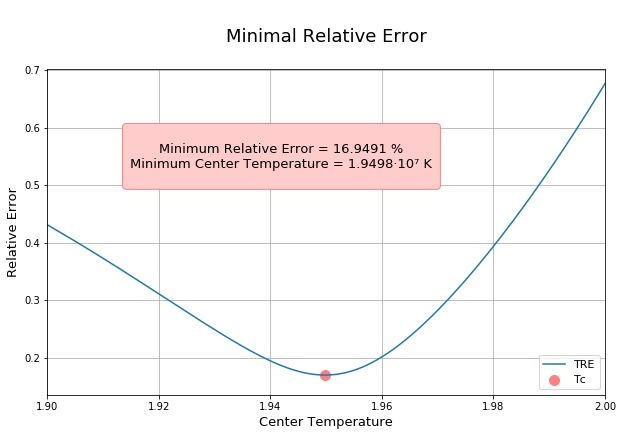

In [65]:
# We can now plot the relative error
import matplotlib.pyplot as plt
from numpy import linspace, argmin
%matplotlib inline

T_prueba = linspace(1.9,2,1000)


fig, ax = plt.subplots(figsize = [10,6])

error_list = list(map(minRelError, T_prueba))
pos_min = argmin(error_list)

ax.plot(T_prueba, error_list, label = "TRE")
ax.scatter(T_prueba[pos_min], error_list[pos_min], color = (1., 0.5, 0.5), s = 100, label = "Tc")
ax.set_title("\nMinimal Relative Error\n", fontsize = 18)
ax.set_xlabel("Center Temperature", fontsize = 13)
ax.set_ylabel("Relative Error", fontsize = 13)
ax.text(1.942, 0.55, "\nMinimum Relative Error = {:.4f} %\n Minimum Center Temperature = {:.4f}·10⁷ K \n"
         .format(100 * error_list[pos_min], T_prueba[pos_min]), size = 13,
         ha = "center", va = "center",bbox = dict(boxstyle="round",
         ec = (1., 0.5, 0.5), fc = (1., 0.8, 0.8)))
ax.set_xlim(1.9,2)
ax.legend(loc='lower right', fontsize = 11)
ax.grid()
plt.show();

warnings.filterwarnings("ignore") 

* * *